<span style="font-size:18px;"><strong>Code to create a NetCDF file for Parallel Ice Sheet Models</strong></span>

Functions to be loaded for the code.

In [11]:
import rasterio
import xarray as xr
import numpy as np
import rasterio
import netCDF4 as nc
from rasterio.plot import show
import matplotlib.pyplot as plt
import contextily as ctx
from rasterio.warp import transform_bounds

def create_constant_raster_with_metadata(input_tif_path, output_tif_path, constant_value):
    # Open the original TIFF file to get metadata
    with rasterio.open(input_tif_path) as src:
        # Read metadata
        metadata = src.meta.copy()
        transform = src.transform
        crs = src.crs
        
        # Get dimensions and data type
        width = src.width
        height = src.height
        dtype = src.dtypes[0]
        
        # Create an array with constant values
        data = np.full((height, width), constant_value, dtype=dtype)
        
        # Update metadata to reflect the data array
        metadata.update({
            'dtype': dtype,
            'count': 1,  # Number of bands
            'driver': 'GTiff'
        })
        
        # Write the new raster to a GeoTIFF file
        with rasterio.open(output_tif_path, 'w', **metadata) as dst:
            dst.write(data, 1)  # Write data to band 1
            
            
def create_lateral_gradient_raster_with_metadata(input_tif_path, output_tif_path, start_value, end_value):
    #First value is on the left, second is to the right
    # Open the original TIFF file to get metadata
    with rasterio.open(input_tif_path) as src:
        # Read metadata
        metadata = src.meta.copy()
        transform = src.transform
        crs = src.crs
        
        # Get dimensions and data type
        width = src.width
        height = src.height
        dtype = src.dtypes[0]
        
        # Create an array with lateral gradient values
        data = np.linspace(start_value, end_value, width, dtype=dtype)
        data = np.tile(data, (height, 1))  # Repeat the gradient for each row
        
        # Update metadata to reflect the data array
        metadata.update({
            'dtype': dtype,
            'count': 1,  # Number of bands
            'driver': 'GTiff'
        })
        
        # Write the new raster to a GeoTIFF file
        with rasterio.open(output_tif_path, 'w', **metadata) as dst:
            dst.write(data, 1)  # Write data to band 1

def create_vertical_gradient_raster_with_metadata(input_tif_path, output_tif_path, start_value, end_value):
    #Top is first value, bottom is second
    # Open the original TIFF file to get metadata
    with rasterio.open(input_tif_path) as src:
        # Read metadata
        metadata = src.meta.copy()
        transform = src.transform
        crs = src.crs
        
        # Get dimensions and data type
        width = src.width
        height = src.height
        dtype = src.dtypes[0]
        
        # Create an array with vertical gradient values
        data = np.linspace(start_value, end_value, height, dtype=dtype)
        data = np.tile(data[:, None], (1, width))  # Repeat the gradient for each column
        
        # Update metadata to reflect the data array
        metadata.update({
            'dtype': dtype,
            'count': 1,  # Number of bands
            'driver': 'GTiff'
        })
        
        # Write the new raster to a GeoTIFF file
        with rasterio.open(output_tif_path, 'w', **metadata) as dst:
            dst.write(data, 1)  # Write data to band 1
            
def create_latitude_raster(input_tif_path, output_tif_path):
    # Open the original TIFF file to get metadata and geographical information
    with rasterio.open(input_tif_path) as src:
        # Read metadata
        metadata = src.meta.copy()
        transform = src.transform
        crs = src.crs

        # Get dimensions
        width = src.width
        height = src.height

        # Create an empty array to store latitude values
        latitude_data = np.empty((height, width), dtype=np.float32)

        # Calculate latitude values for each pixel
        for row in range(height):
            for col in range(width):
                lon, lat = transform * (col, row)
                latitude_data[row, col] = lat
        
        # Update metadata to reflect the data array
        metadata.update({
            'dtype': 'float32',
            'count': 1,  # Number of bands
            'driver': 'GTiff'
        })

        # Write the new raster to a GeoTIFF file
        with rasterio.open(output_tif_path, 'w', **metadata) as dst:
            dst.write(latitude_data, 1)  # Write data to band 1            
            
def create_longitude_raster(input_tif_path, output_tif_path):
    # Open the original TIFF file to get metadata and geographical information
    with rasterio.open(input_tif_path) as src:
        # Read metadata
        metadata = src.meta.copy()
        transform = src.transform
        crs = src.crs

        # Get dimensions
        width = src.width
        height = src.height

        # Create an empty array to store longitude values
        longitude_data = np.empty((height, width), dtype=np.float32)

        # Calculate longitude values for each pixel
        for row in range(height):
            for col in range(width):
                lon, lat = transform * (col, row)
                longitude_data[row, col] = lon
        
        # Update metadata to reflect the data array
        metadata.update({
            'dtype': 'float32',
            'count': 1,  # Number of bands
            'driver': 'GTiff'
        })

        # Write the new raster to a GeoTIFF file
        with rasterio.open(output_tif_path, 'w', **metadata) as dst:
            dst.write(longitude_data, 1)  # Write data to band 1

def geotiff_to_netcdf(geotiff_path, netcdf_path):
    # Open the GeoTIFF file
    with rasterio.open(geotiff_path) as src:
        # Read the data from the first band
        data = src.read(1)  # Assuming single-band GeoTIFF, adjust as needed
        
        # Get GeoTIFF metadata
        transform = src.transform
        crs = src.crs
        width = src.width
        height = src.height
        
        # Create coordinate arrays
        x = np.arange(width) * transform[0] + transform[2]
        y = np.arange(height) * transform[4] + transform[5]
        y, x = np.meshgrid(y, x, indexing='ij')  # 'ij' indexing for correct coordinate orientation

        # Create an xarray.DataArray
        data_array = xr.DataArray(
            data,
            dims=("y", "x"),
            coords={"y": y[:, 0], "x": x[0, :]},
            attrs={
                "description": "Converted from GeoTIFF",
                "crs": str(crs),
            },
        )

        # Create an xarray.Dataset
        dataset = xr.Dataset({"band1": data_array})
        
        # Write the dataset to a NetCDF file
        dataset.to_netcdf(netcdf_path)
    

def print_netcdf_variables(netcdf_path):
    # Open the NetCDF file
    dataset = xr.open_dataset(netcdf_path)
    
    # Print the dataset overview
    print("Dataset Overview:")
    print(dataset)
    
    # Print each variable with its attributes
    print("\nVariables and their attributes:")
    for var_name in dataset.data_vars:
        variable = dataset[var_name]
        print(f"Variable: {var_name}")
        print(f"Shape: {variable.shape}")
        print(f"Dims: {variable.dims}")
        print(f"Attributes: {variable.attrs}")
        print()

Assign the DEM file to DEM_extent variable and convert any existing geotiffs to NetCDF files as shown with DEM_extent. The cell below also creates the latitude and longitude tiff files needed. The area depicted by the DEM is also shown here to check the area studied is correct.

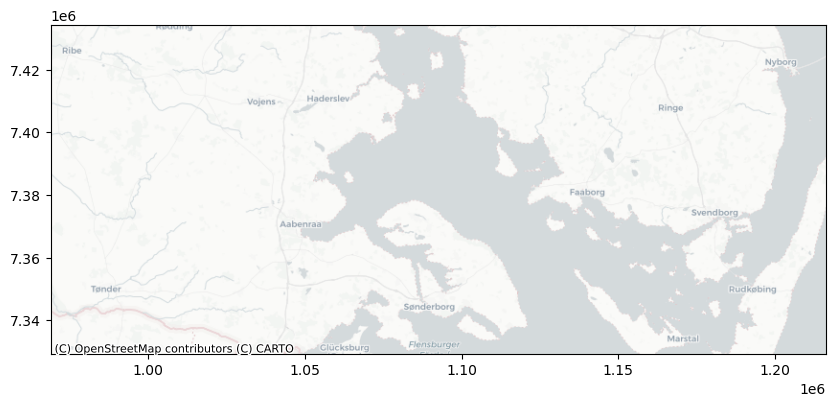

In [12]:
DEM_extent = 'output_hh.tif'
geotiff_to_netcdf(DEM_extent, 'topg.nc')
create_longitude_raster(DEM_extent, 'Longitude_test.tif')
create_latitude_raster(DEM_extent, 'Latitude_test.tif')
geotiff_to_netcdf('Longitude_test.tif', 'Longitude_test.nc')
geotiff_to_netcdf('Latitude_test.tif', 'Latitude_test.nc')

# Open the GeoTIFF file
dataset = rasterio.open(DEM_extent)

# Get the bounds of the image
bounds = dataset.bounds

# Transform the bounds to Web Mercator
bounds_mercator = transform_bounds(dataset.crs, 'EPSG:3857', *bounds)

# Plotting the GeoTIFF
fig, ax = plt.subplots(figsize=(10, 10))
show((dataset, 1), ax=ax)

# Adding a different basemap
ax.set_xlim(bounds_mercator[0], bounds_mercator[2])
ax.set_ylim(bounds_mercator[1], bounds_mercator[3])
ctx.add_basemap(ax, crs='EPSG:3857', source=ctx.providers.CartoDB.Positron)

plt.show()

# Close the dataset
dataset.close()
#Create any simple rasters
list_of_netcdf = ['topg.nc']

To create any rasters run the cell below.

In [13]:
num_variables = int(input("Enter how many variables are needed along with latitude and longitude: "))

#Create any simple rasters
list_of_netcdf = ['topg.nc']

for i in range(num_variables):
    raster_type = int(input('For constant raster enter 1, horizontally varying enter 2, vertically varying enter 3: '))
    if (raster_type == 1):
        name = input("Enter name of variable (with .tif): ")
        nc_name = name.replace('.tif', '.nc')
        value = int(input("Enter constant value: "))
        create_constant_raster_with_metadata(DEM_extent, name, value)
        geotiff_to_netcdf(name, nc_name)
        list_of_netcdf.append(nc_name)
    elif (raster_type == 2):
        name = input("Enter name of variable (including .tif): ")
        nc_name = name.replace('.tif', '.nc')
        start_value = int(input("Enter starting value: "))
        end_value = int(input('Enter ending value: '))
        create_lateral_gradient_raster_with_metadata(DEM_extent, name, start_value, end_value)
        geotiff_to_netcdf(name, nc_name)
        list_of_netcdf.append(nc_name)
    else:
        name = input("Enter name of variable (including .tif): ")
        nc_name = name.replace('.tif', '.nc')
        start_value = int(input("Enter starting value: "))
        end_value = int(input('Enter ending value: '))
        create_vertical_gradient_raster_with_metadata(DEM_extent, name, start_value, end_value)
        geotiff_to_netcdf(name, nc_name)
        list_of_netcdf.append(nc_name)

Enter how many variables are needed along with latitude and longitude: 4
For constant raster enter 1, horizontally varying enter 2, vertically varying enter 3: 1
Enter name of variable (with .tif): thk.tif
Enter constant value: 0
For constant raster enter 1, horizontally varying enter 2, vertically varying enter 3: 1
Enter name of variable (with .tif): bheatflx.tif
Enter constant value: 1
For constant raster enter 1, horizontally varying enter 2, vertically varying enter 3: 2
Enter name of variable (including .tif): precip.tif
Enter starting value: 12
Enter ending value: 56
For constant raster enter 1, horizontally varying enter 2, vertically varying enter 3: 3
Enter name of variable (including .tif): air_temp.tif
Enter starting value: 12
Enter ending value: 16


Run this cell if any additional NetCDF files need to be added

In [14]:

extra = int(input('If there are any netcdf files to add type the number to add otherwise type 0: '))
if (extra != 0):
    print('Type the individual file names below')
    for i in extra:
        name = input('Type a NetCDF name: ')
        list_of_netcdf.append(nc_name)

If there are any netcdf files to add type the number to add otherwise type 0: h.nc


ValueError: invalid literal for int() with base 10: 'h.nc'

Ensure all netcdf file names are correctly added to the list_of_netcdf list. Then run the cell below to merge into one netCDF file.

In [15]:
print('load in the netcdf data')

#Read in topography netcdf file
##Load in NC data file

set_attributes = nc.Dataset('topg.nc','r')
variables_in_variable = list(set_attributes.variables.keys())
xCells=set_attributes.variables['band1'].shape[1]
yCells=set_attributes.variables['band1'].shape[0]
x=set_attributes.variables[variables_in_variable[0]][:].copy()
y=set_attributes.variables[variables_in_variable[1]][:].copy()
set_attributes.close()

# Specify the output file name
outname = input('Type name of overall netcdf file to be made: ')

# Create a new NetCDF file using PISMDataset
Nc = nc.Dataset(outname, 'w', format='NETCDF4')

# Create dimensions
y_dim = Nc.createDimension('y', yCells)  # Replace 'y' with the actual size or None for unlimited dimension
x_dim = Nc.createDimension('x', xCells)  # Replace 'x' with the actual size or None for unlimited dimension

# If you need a time-dependent dimension, create it separately
time_dim = Nc.createDimension('time', None)  # None for unlimited dimension

#Need to get in projection information? Or copy over using ncks etc.
#If there are issues with the lat and lon variables,these may be possible 
#to create from scratch using lines 71-146 in 'pism_input.py' in the pism-ais folder.
mapping = Nc.createVariable("mapping",'c')
mapping.ellipsoid = "WGS84"
mapping.false_easting = 0.
mapping.false_northing = 0.
mapping.grid_mapping_name = "polar_stereographic"
mapping.latitude_of_projection_origin = -90.
mapping.standard_parallel = -71.
mapping.straight_vertical_longitude_from_pole = 0.

variable_names = []
for i in list_of_netcdf:
    variable_name = i.split('.')[0]
    a = nc.Dataset(i,'r')
    to_a = a.variables[list(a.variables.keys())[2]][:,:].copy()
    a.close()
    aData=np.zeros((yCells,xCells))
    aData[:,:]=to_a[:,:]
    # Create the 2D variable
    print('All the requests below refer to variable',i)
    long_name = input('Enter the long name of the variable for: ')
    standard_name = input('Enter the standard name of the variable for: ')
    units = input('Enter the units of the variable for: ')
    reference = input('Enter the reference of the variable for: ')
    a_var = Nc.createVariable(variable_name, 'f4', ('y','x'))
    # Add attributes to the 2D variable 
    a_var.long_name = long_name
    a_var.standard_name = standard_name
    a_var.units = units
    a_var.grid_mapping = "mapping"
    a_var.coordinates = "lon lat"
    a_var.reference = reference
    a_var[:] = aData[:,:]
    

Lat=nc.Dataset('Latitude_test.nc', 'r')
Lon=nc.Dataset('Longitude_test.nc', 'r')
to_Lat=Lat.variables[list(Lat.variables.keys())[2]][:,:].copy()
to_Lon=Lon.variables[list(Lon.variables.keys())[2]][:,:].copy()
latData=np.zeros((yCells,xCells))
latData[:,:]=to_Lat[:,:]
lonData=np.zeros((yCells,xCells))
lonData[:,:]=to_Lon[:,:]
Lon.close()
Lat.close()
#lat and lon coordinates must NOT have mapping or coordinate attributes.
# Create the 2D variable
lat_var = Nc.createVariable('Latitude', 'f4', ('y','x'))
# Add attributes to the 2D variable 
lat_var.long_name = "Latitude"
lat_var.standard_name = "latitude"
lat_var.units = "degreesN"
lat_var[:] = latData[:,:]


# Create the 2D variable
lon_var = Nc.createVariable('Longitude', 'f4', ('y','x'))

# Add attributes to the 2D variable 
lon_var.long_name = "Longitude"
lon_var.standard_name = "longitude"
lon_var.units = "degreesE"
lon_var[:] = lonData[:,:]
print(Nc.variables)
Nc.close()

load in the netcdf data
Type name of overall netcdf file to be made: output.nc
All the requests below refer to variable topg.nc
Enter the long name of the variable for: Topography
Enter the standard name of the variable for: topg
Enter the units of the variable for: meters
Enter the reference of the variable for: hjfj et al.
All the requests below refer to variable thk.nc
Enter the long name of the variable for: Thickness
Enter the standard name of the variable for: thk
Enter the units of the variable for: meters
Enter the reference of the variable for: jffjhf et al
All the requests below refer to variable bheatflx.nc
Enter the long name of the variable for: Heat Flux
Enter the standard name of the variable for: bheatflux
Enter the units of the variable for: degrees
Enter the reference of the variable for: fbf et al.
All the requests below refer to variable precip.nc
Enter the long name of the variable for: Precipitation
Enter the standard name of the variable for: precip
Enter the uni